In [1]:
# Import necessary libraries

import SimpleITK as sitk
import os
import time
import matplotlib.pyplot as plt
import glob
import natsort
from ipywidgets import interact, fixed
from IPython.display import clear_output 
from tqdm import tqdm
%matplotlib inline

In [2]:
# Input zone hardcoded variables

path_of_mr_navigators           =               '/Users/lalith/Documents/GAN/MR-navigators' # change this
wild_card_string                =               'Transform_MRnav_*nii'
path_of_tfms                    =               '/Users/lalith/Documents/GAN/MR-navigators';

In [3]:
# Program start


# Utility functions borrowed from Simple ITK's notebook

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
# Registration module

registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)


registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()


# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


    


0

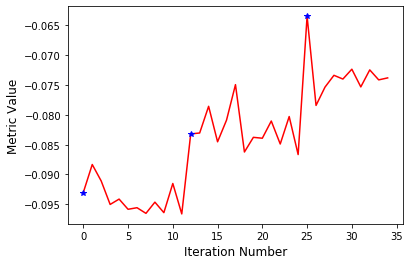

100%|██████████| 13/13 [02:05<00:00,  9.69s/it]

itk::simple::Transform
 Euler3DTransform (0x7fea91a772d0)
   RTTI typeinfo:   itk::Euler3DTransform<double>
   Reference Count: 2
   Modified Time: 36964546
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999974 0.00223773 -0.00686939 
     -0.0021487 0.999914 0.0129411 
     0.00689776 -0.012926 0.999893 
   Offset: [0.219212, 1.1403, 6.92257]
   Center: [0, 0, 0]
   Translation: [0.219212, 1.1403, 6.92257]
   Inverse: 
     0.999974 -0.0021487 0.00689776 
     0.00223773 0.999914 -0.012926 
     -0.00686939 0.0129411 0.999893 
   Singular: 0
   Euler's angles: AngleX=-0.0129264 AngleY=-0.00689839 AngleZ=-0.00223792
   m_ComputeZYX = 0



In [24]:
# Registration cycle 

os.chdir(path_of_mr_navigators) # go to the path of the mr navigators 
mr_nav_files                    =               (glob.glob(wild_card_string))
mr_nav_files                    =               (natsort.natsorted(mr_nav_files))
path_fixed_img                  =               os.path.join(path_of_mr_navigators,mr_nav_files[0])
for i in tqdm(range(1,(len(mr_nav_files))):
    time.sleep(0.5)
    print('Processing '+mr_nav_files[i]+'...')
    path_moving_img             =               os.path.join(path_of_mr_navigators,mr_nav_files[i])
    fixed_img                   =               sitk.ReadImage(path_fixed_img)
    registration_method.SetInitialTransform(sitk.Euler3DTransform())
    moving_img                  =               sitk.ReadImage(path_moving_img)
    final_transform             =               registration_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32),sitk.Cast(moving_img, sitk.sitkFloat32))
    tfm_file_name               =               str(i+1)+'->'+str(1)+'.tfm'
    print(final_transform)
    sitk.WriteTransform(final_transform, os.path.join(path_of_tfms, tfm_file_name))

In [21]:
print(final_transform)

itk::simple::Transform
 AffineTransform (0x7fea914e3760)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 2
   Modified Time: 27978736
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.962757 0.0109912 -0.00348754 
     0.000213898 0.95945 0.00266308 
     0.00326015 -0.0178245 0.929204 
   Offset: [-3.31023, -0.0963924, 4.13743]
   Center: [0, 0, 0]
   Translation: [-3.31023, -0.0963924, 4.13743]
   Inverse: 
     1.03867 -0.0118257 0.0039323 
     -0.000221433 1.04221 -0.00298778 
     -0.00364847 0.0200337 1.07612 
   Singular: 0

